## Data Cleaning Plan

We have three data sets:
- Markers' bios and metadata (markers_bios)
- Followers' bios and metadata (followers_bios)
- All brands and their followers (markers-followers)


Step by step plan:
1. Load the bios of followers, and the marker-follower file. 
    - Provide summary statistics of users and brands. How many brands do we have? How many followers? Any missing data, duplicates etc.?

2. Filter on marker-follower df:
    - Create a dictionary of counts brands per follower
    - Remove users that follow less than 5 (or more) brands
    - Continuously track numbers of users removed
    - Match the Follower_Ids in the now filtered marker-follower df with the follower-bio df. As such, the follower bios will only include users that follow more than five brands. Subsequent filters will be on the correct users (up to date follower-bios).

3. Do the filters on the follower-bios:
    - Remove users with less than 25 followers
    - Remove users with less than 100 tweets

4. Filter based on language: keep only french accounts









In [2]:
# Standard library imports
import csv
import html
import os
import re
import sys
from collections import defaultdict
from datetime import datetime

# Third-party library imports
import ftfy
import geonamescache
import locationtagger
import matplotlib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import psutil
import regex
import seaborn as sns
import spacy
from joblib import Parallel, delayed
from langdetect import detect_langs, LangDetectException, DetectorFactory
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from unidecode import unidecode

import sys
sys.path.insert(0, '../Utility files')
import langutils
from langutils import *
import importlib

# Local application/library specific imports
import utils2
from utils2 import *

## 1. Load files and summary stats

In [7]:
# # Load the data files and rename ID columns
importlib.reload(utils2)

# Load markers-followers
load_path = '/home/livtollanes/SocialMarkers'
file = 'markers_followers_2023-05-19.csv'

req_cols = ['id', 'follower_id']
dtypes = {'id': 'object',
          'follower_id': 'object'}

markers_followers = utils2.fileloader(load_path, file, req_cols, dtypes)


#rename the twittwer id column to follower id 
markers_followers.rename(columns={'id':'marker_id'}, inplace=True)

In [8]:
# Load the followers bios and rename ID columns
load_path = '/home/livtollanes/SocialMarkers'
file = 'markers_followers_bios_2023-05-19.csv'

req_cols = ['twitter_id', 'id', 'screen_name', 'description', 'location', 'tweets', 'followers', 'friends', 'likes', 'lists','timestamp_utc']

dtypes = {
    'twitter_id': 'object',
    'id': 'object',
    'screen_name': 'object',
    'description': 'object',
    'location': 'object',
    'tweets': 'float64',
    'followers': 'float64',
    'friends': 'float64',
    'witheld_in_countries': 'float64'
}

followers_bios = utils2.fileloader(load_path, file, req_cols, dtypes)



#rename the twittwer id column to follower id 
followers_bios.rename(columns={'twitter_id':'follower_id'}, inplace=True)

Summary statistics

In [9]:
utils2.summary_stats(followers_bios, print_dtypes=False)

Shape of DataFrame:  (70666646, 11)

Columns in DataFrame:  ['follower_id', 'id', 'screen_name', 'description', 'timestamp_utc', 'location', 'tweets', 'followers', 'friends', 'likes', 'lists']

Number of unique values in 'follower_id':  70666646
Number of duplicate values in 'follower_id':  0

Number of unique values in 'id':  70642661
Number of duplicate values in 'id':  23984

Number of missing values in each column:
'follower_id':  0
'id':  23985
'screen_name':  23986
'description':  42027215
'timestamp_utc':  23985
'location':  47956041
'tweets':  23985
'followers':  23985
'friends':  23985
'likes':  23985
'lists':  23985

Number of duplicate rows:  0


In [10]:
importlib.reload(utils2)
utils2.summary_stats(markers_followers, print_dtypes=False)

Shape of DataFrame:  (126345412, 2)

Columns in DataFrame:  ['marker_id', 'follower_id']

Number of unique values in 'follower_id':  70636295
Number of duplicate values in 'follower_id':  55709117

Number of unique values in 'marker_id':  236
Number of duplicate values in 'marker_id':  126345176

Number of missing values in each column:
'marker_id':  0
'follower_id':  0

Number of duplicate rows:  2357493


In [11]:
# Sort the DataFrame to ensure that duplicates are next to each other
markers_followers_sorted = markers_followers.sort_values(by=list(markers_followers.columns))

# Find duplicates in the sorted DataFrame
duplicates = markers_followers_sorted[markers_followers_sorted.duplicated(keep=False)]

# Print the first 10 rows of duplicates (5 pairs)
print(duplicates.head(10))

         marker_id          follower_id
81032594  25053299            100000025
89256298  25053299            100000025
79323950  25053299  1000001004220420096
87547795  25053299  1000001004220420096
79369517  25053299  1000001771266232320
87593356  25053299  1000001771266232320
79562687  25053299           1000001815
87786516  25053299           1000001815
79371019  25053299  1000002790238777352
87594858  25053299  1000002790238777352


In [12]:
duplicates.shape

(4714986, 2)

In [6]:
#drop the duplicates in markers_followers
markers_followers.drop_duplicates(keep='first', inplace=True)

In [7]:
markers_followers.shape

(123987919, 2)

In [8]:
compare_column_values(followers_bios, markers_followers, 'follower_id')

There are 30351 unique values in df1 that don't exist in df2.
There are 0 unique values in df2 that don't exist in df1.


## 2. Filter the marker-follower df

- Filter the marker-follower df:
    - Remove users that follow less than 5 (or more) brands

    - Continuously track numbers of users removed
    
    - Match the Follower_Ids in the now filtered marker-follower df with the follower-bio df. As such, the follower bios 
    will only include users that follow more than five brands. Subsequent filters will be on the correct users (up to date follower-bios).

Remove users that follow less than 5 brands

In [9]:
n = 5  # minimal number of brands followed required to be included in the analysis
importlib.reload(utils2)
markers_followers_5 = utils2.filter_followers(markers_followers, 'follower_id', n)

66693204 followers follow less than 5 brands (94.42% of the total followers).
After removing these followers, 3943091 followers are left (5.58% of the followers in the inputted df).


In [12]:
#number of unique brands left

# Get the unique marker_id values in the original and filtered DataFrames
original_brands = set(markers_followers['marker_id'].unique())
filtered_brands = set(markers_followers_5['marker_id'].unique())

# Find the brands that are in the original DataFrame but not in the filtered DataFrame
removed_brands = original_brands - filtered_brands

# Print the removed brands
print("Removed brands:", removed_brands) #corresponds to "Napapijiri97", which kindof sounds like a fake profile


Removed brands: {'1059975643'}


Match the IDs in the filtered marker-follower df with the follower bio df, so that the follower bios only are for those who follow at least 5 brands

In [13]:
followers_bios_5 = utils2.streamline_IDs(source = markers_followers_5, df_tofilter= followers_bios, 'follower_id')

Number of unique follower_id in source DataFrame: 3943091
Number of unique follower_id in filtered DataFrame after filtering: 3943091
Removed 66723555 rows from the DataFrame to be filtered.
3943091 rows are left in the filtered DataFrame.


In [14]:
compare_column_values(followers_bios_5, markers_followers_5, 'follower_id')   

There are 0 unique values in df1 that don't exist in df2.
There are 0 unique values in df2 that don't exist in df1.


## 3. Do the filters on the follower-bios:
- Remove users with less than 25 followers
- Remove users with less than 100 tweets
- Update the markers-followers df to match the now filtered bio df
- Filter based on language: keep only french accounts


In [15]:

followers_bios_fullfilter = utils2.filter_by_tweets_and_followers(followers_bios_5, min_followers= 25, min_tweets= 100)


Removed 2750559 rows.
1192532 rows are left.


Again, remove the follower_Ids in markers-followers that don't occur in the newly filtered  followers_bios_nd5_tweets_followers

In [16]:
markers_followers_fullfilter = utils2.streamline_IDs(source= followers_bios_fullfilter, df_tofilter=markers_followers_5, column='follower_id')

Number of unique follower_id in source DataFrame: 1192532
Number of unique follower_id in filtered DataFrame after filtering: 1192532
Removed 18992709 rows from the DataFrame to be filtered.
9614122 rows are left in the filtered DataFrame.


In [17]:
compare_column_values(followers_bios_fullfilter, markers_followers_fullfilter , 'follower_id')

There are 0 unique values in df1 that don't exist in df2.
There are 0 unique values in df2 that don't exist in df1.


In [19]:
#Before writing ti csv, clean description column to avoid writing problems
importlib.reload(utils2)

followers_bios_fullfilter = utils2.process_description(followers_bios_fullfilter, 'description')

In [21]:
summary_stats(markers_followers_fullfilter, print_dtypes=False)

Shape of DataFrame:  (9614122, 2)

Columns in DataFrame:  ['marker_id', 'follower_id']



Number of unique values in 'follower_id':  1192532
Number of duplicate values in 'follower_id':  8421590

Number of unique values in 'marker_id':  235
Number of duplicate values in 'marker_id':  9613887

Number of missing values in each column:
'marker_id':  0
'follower_id':  0

Number of duplicate rows:  0


In [22]:
# # #Now write the two dfs to csvs to save them in case something happens
markers_followers_fullfilter.to_csv('/home/livtollanes/NewData/markers_followers_cleaned_nolang.csv', encoding='utf-8', index=False)

followers_bios_fullfilter.to_csv('/home/livtollanes/NewData/followers_bios_cleaned_nolang3.csv', sep=',', encoding='utf-8', index=False, quoting=csv.QUOTE_NONNUMERIC)



## 4. Filter based on language: keep only french accounts
- Use language recognition alorithms to filter the follower_bios. 
- We only want french language bios to be included


In [3]:
#Load marker followers
full_path1 = '/home/livtollanes/NewData/markers_followers_cleaned_nolang.csv'
req_cols = ['marker_id', 'follower_id']
dtypes = {'marker_id': 'object',
          'follower_id': 'object'}

markers_followers_clean = pd.read_csv(full_path1, encoding='utf-8', dtype=dtypes, usecols=req_cols)

In [4]:
# #Loading the followers bios (with cleaned description column)
full_path = '/home/livtollanes/NewData/followers_bios_cleaned_nolang3.csv'

req_cols = ['follower_id', 'screen_name', 'description', 'description_cleantext', 'location', 'tweets', 'followers', 'friends', 'likes', 'lists','timestamp_utc']

dtypes = {
    'follower_id': 'object',
    'screen_name': 'object',
    'description': 'object',
    'description_cleantext': 'object',
    'location': 'object',
    'tweets': 'float64',
    'followers': 'float64',
    'friends': 'float64'
}

follower_bios_cleaned3 = pd.read_csv(full_path, usecols=req_cols, dtype=dtypes, engine= 'python')

In [5]:
compare_column_values(follower_bios_cleaned3, markers_followers_clean, 'follower_id')

#The follower_ids are still streamlined, indicating that writing and reading of the cleaned dfs was successful

There are 0 unique values in df1 that don't exist in df2.
There are 0 unique values in df2 that don't exist in df1.


In [6]:
#should probably do summary stats on the dfs again, to make sure that no strange things have happened during the cleaning process
summary_stats(follower_bios_cleaned3, print_dtypes= False)

Shape of DataFrame:  (1192532, 11)

Columns in DataFrame:  ['follower_id', 'screen_name', 'description', 'timestamp_utc', 'location', 'tweets', 'followers', 'friends', 'likes', 'lists', 'description_cleantext']

Number of unique values in 'follower_id':  1192532
Number of duplicate values in 'follower_id':  0

Number of missing values in each column:
'follower_id':  0
'screen_name':  0
'description':  296871
'timestamp_utc':  0
'location':  376685
'tweets':  0
'followers':  0
'friends':  0
'likes':  0
'lists':  0
'description_cleantext':  313934

Number of duplicate rows:  0


In [7]:
summary_stats(markers_followers_clean, print_dtypes= False)

Shape of DataFrame:  (9614122, 2)

Columns in DataFrame:  ['marker_id', 'follower_id']

Number of unique values in 'follower_id':  1192532
Number of duplicate values in 'follower_id':  8421590

Number of unique values in 'marker_id':  235
Number of duplicate values in 'marker_id':  9613887

Number of missing values in each column:
'marker_id':  0
'follower_id':  0

Number of duplicate rows:  0


Here comes the language detection

- First language detection is with the langdetect package. This package is based on Google's language detection API. On medium, it is actually reported that this package may not perform very accurate on short or mixed lnaguage texts, which is exactly what we are deailing with in twitter bios. 
- Gcld3 mmight be better at handling short text inputs like bios. By reading the documentation, gcld3 seems to be more fitting for social media data language detection

In [8]:
importlib.reload(langutils)
# Create a copy of the DataFrame for each function
follower_bios_cleaned3_copy1 = follower_bios_cleaned3.copy()
#follower_bios_cleaned3_copy2 = follower_bios_cleaned3.copy()

# Use the copied DataFrames in the functions
lang = langutils.add_and_detect_language(follower_bios_cleaned3_copy1, 'description_cleantext', seed = 3)
#lang2 = utils2.detect_language_gcld3(follower_bios_cleaned3_copy2, 'description_cleantext', n_jobs=-1)

In [9]:
lang.head()

,follower_id,screen_name,description,timestamp_utc,location,tweets,followers,friends,likes,lists,description_cleantext,language
0,30797693,AVMGDIGITALHD,THE NEW DIGITAL STATION!!! \nfollowed by @ROCN...,1.239593e+09,NaN,73584.0,777.0,1504.0,250.0,12.0,THE NEW DIGITAL STATION!!! followed by @ROCNAT...,en
1,134483898,Ferdlarez,Electricist Professional,1.271603e+09,Venezuela,7868.0,204.0,2182.0,1552.0,2.0,Electricist Professional,en
2,2779899894,nestorale3,En una biografia no me conoceras relamente :3 ...,1.409374e+09,Valencia _ Los guayos city,990.0,180.0,1101.0,488.0,0.0,En una biografia no me conoceras relamente :3 ...,es
3,487765672,bbbbbbrieuc,"les gangsters ne dansent pas,\nmais ce soir c'...",1.328812e+09,NaN,4979.0,88.0,306.0,18415.0,2.0,"les gangsters ne dansent pas,mais ce soir c'es...",fr
4,3139392851,lermitevvv,NaN,1.428301e+09,NaN,17245.0,1033.0,1005.0,14468.0,9.0,NaN,unknown


In [12]:
#Language stats
importlib.reload(langutils)
langutils.calculate_language_percentages(lang, 'language')

French:  268930 ( 22.551176823766575 %)
English:  353132 ( 29.611951712826155 %)
Unknown:  327271 ( 27.443372588743948 %)
Other:  243199 ( 20.393498874663315 %)
NaN in description_cleantext:  313934 ( 26.324995891095586 %)


### Manually creating test sets to compare the two language detection methods

For the langdetect df

In [37]:
test1 = lang.sample(n=100, random_state=1)
test2 = lang2.sample(n=100, random_state=1)

NameError: name 'lang2' is not defined

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
test1[['screen_name', 'location','description_cleantext', 'language']]

In [ ]:


true_labels = {
    'MorganJewelers1': 'non_fr',
    'LeighAnnTowne': 'non_fr',
    'ALBrutel': 'NA',
    'Fonkwadiour1': 'non_fr',
    'JUSTINAGROSSO': 'NA',
    'SarahRadif': 'non_fr',
    'CarineMayol': 'NA',
    'ManonMondou': 'fr',
    'erickleangar': 'NA',
    'elaineguimarae': 'non_fr',
    'danyunes': 'fr',
    'kuronapilled': 'non_fr',
    'KiriYaji': 'non_fr',
    'floriannisolle': 'fr',
    'Naman93726237': 'fr', #french but from guinea
    'doktor_vananga': 'non_fr', 
    'Slaiidh': "non_fr", #wrote non. could be another language
    'StarRaull': "non_fr",
    'SPeperstraete': 'non_fr',
    'yorgaine_lyon69': 'fr',
    'blinameta': 'non_fr',
    'AnnaRus75': 'non_fr',
    'BernTurner': 'NA',
    'lauriebeebe2': 'non_fr',
    'JeremyyPalazzo': 'NA',
    'GalerieCoulange': 'fr',
    'HaziqkaJ': 'NA',
    'DaraCheick': 'non_fr', #but seems to belong to a french uni
    'mmdlbdrny2': 'NA',
    'blandineleonie': 'fr',
    'CarlosO324': 'non_fr',
    'joshuatoney3': 'non_fr',
    'StephaneWayler': 'fr',
    'JessieV_214': 'non_fr',
    'Apartofsuzanne': 'non_fr',#but writes that she is french, and location is Paris
    'katuxka1': 'NA',
    'tamaitanya': 'NA',
    'sulagnasays': 'non_fr',
    'nicolesimon': 'non_fr',
    'lunasitah': 'non_fr',
    'ln971': 'fr',
    'olive_cas': 'non_fr',
    'Mercedeszatfc': 'NA',
    'hady_saad': 'non_fr',
    'GatienLeroux': 'fr',
    'Meluxiam': 'non_fr',
    'yulimadera10': 'non_fr',
    'RyanBrossault': 'fr',
    'FlotillaMRY': 'non_fr',
    'love98_daniela': 'non_fr',
    'jucag4115': 'NA',
    'Bxwiz': 'non_fr',
    'MLECOMTE': 'fr',
    'DelgadoJanahi': 'non_fr',
    'f1rmin': 'fr',
    'SylvainWalczak': 'NA',
    'SoyLigiawn': 'non_fr',
    'javielo26': 'non_fr',
    'CherrybangMUA': 'non_fr',
    '1927_albert': 'non_fr',
    'aayyoud': 'NA',
    'princessivy28': 'non_fr',
    'drumz420': 'NA',
    'Cjruin': 'non_fr',
    'xXallymayXx': 'non_fr',
    'NaAutacaace': 'fr',
    'RosaLuc15360022': 'non_fr',
    'PatrikWinston': 'non_fr',
    'mwa_sisqo': 'NA',
    'vankrug': 'NA',
    'miktoi': 'non_fr',
    'cescoeco': 'non_fr',
    'floo_ncy': 'NA',
    'Quentin_1411': 'non_fr',
    'Tvy_Tk': 'NA',
    'AlbanLeneveu': 'NA',
    'adh2311': 'non_fr',
    'loaizayose': 'NA',
    'mathilde_Fparis': 'fr',
    'gouillardmichae': 'fr',
    'RomainSprynski': 'fr',
    'styledscience': 'non_fr',
    'amhammadi': 'NA',
    'AliRazaSharif2': 'NA',
    'JahanLutz': 'fr',
    'HERVEJEHL': 'fr',
    'CatherineMSch': 'fr',
    'PoliKeyCo': 'non_fr',
    'HisGraceth': 'non_fr',
    'verstagoat': 'non_fr',
    'G_deLinares': 'fr', 
    'Granadechkou': 'fr',
    'MommaDandine': 'NA',
    'allionesolution': 'non_fr',
    'Ross75016': 'fr',
    'DorignyTheo': 'NA',
    'nikkolasg1': 'non_fr',
    'InesNau': 'fr',
    'FrenchEmperior': 'non_fr',
    'BekaEssick': 'non_fr'}

In [ ]:
def label_language(lang):
    if lang == 'unknown':
        return 'NA'
    elif lang == 'fr':
        return 'fr'
    else:
        return 'non_fr'

test1['pred_lang'] = test1['language'].apply(label_language)
test2['pred_lang'] = test2['language'].apply(label_language)

test1['true_lang'] = test1['screen_name'].map(true_labels)
test2['true_lang'] = test2['screen_name'].map(true_labels)

In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Calculate metrics for test1
print("Metrics for test1:")
print(classification_report(test1['true_lang'], test1['pred_lang']))
print("Accuracy:", accuracy_score(test1['true_lang'], test1['pred_lang']))

# Calculate metrics for test2
print("\nMetrics for test2:")
print(classification_report(test2['true_lang'], test2['pred_lang']))
print("Accuracy:", accuracy_score(test2['true_lang'], test2['pred_lang']))

- Still lack the actual language filtering
- Think of a more sophisticated way to locate french users than only using language. This method should capture french users that write in english, and in french, and avoid selecting users that are writing in french but are not actually french. 

### Filering option overview and actual alnguage filtering

Here, there are some different options. 
- I can go with NER tagging, obtaining country from the location column. My attempts so far were not very successful.
- I can also use a package that retrieves the biggest cities in France, and keep only the rows in the data that matches any of these.

In [13]:
# Overview of number of users with bios and locations
utils2.location_bio_stats(lang)

Unique locations: 231725 (19.4%)
Users with location data: 815847 (68.4%)
Users without location data: 376685 (31.6%)
Users with bios: 878598 (73.7%)
Users without bios: 313934 (26.3%)
Users with both location and bios: 668947 (56.1%)


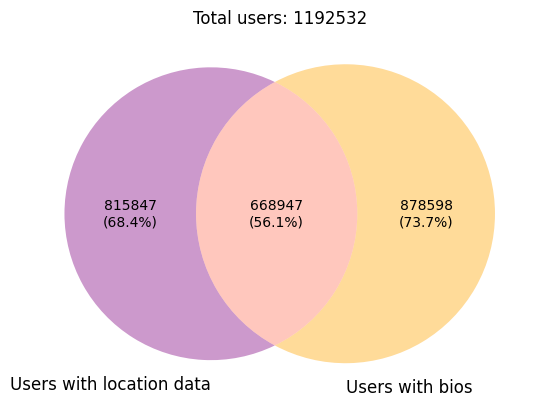

In [14]:
#Plot the intersection of users with bios and locations
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Calculate the number of users for each category
total_users = lang.shape[0]
users_with_location = lang['location'].notna().sum()
users_with_bios = lang['description_cleantext'].notna().sum()
users_with_both = lang[(lang['location'].notna()) & (lang['description_cleantext'].notna())].shape[0]

# Create the Venn diagram with custom colors
v = venn2(subsets=(users_with_location, users_with_bios, users_with_both),
    set_labels=('Users with location data', 'Users with bios'),
    set_colors=('purple', 'orange'))

# Calculate the percentages
location_percentage = users_with_location / total_users * 100
bios_percentage = users_with_bios / total_users * 100
both_percentage = users_with_both / total_users * 100

# Modify the labels of the subsets to include the percentages
v.get_label_by_id('10').set_text(f'{users_with_location}\n({location_percentage:.1f}%)')
v.get_label_by_id('01').set_text(f'{users_with_bios}\n({bios_percentage:.1f}%)')
v.get_label_by_id('11').set_text(f'{users_with_both}\n({both_percentage:.1f}%)')

# Add the total number of users to the title
plt.title(f'Total users: {total_users}')

plt.show()

The NER so far is not working very well.
Try
- bigger language models
- more specific NER tagging tools for french locations
- manually specify a list of the 100 biggest cities in France. set country to France if they match

Location (country) search using GeonamesCache

In [15]:
gc = geonamescache.GeonamesCache()
all_cities = gc.get_cities()

# Filter cities by country code
cities = {k: v for k, v in all_cities.items() if v['countrycode'] == 'FR'}

# Convert the cities dictionary to a list of tuples
cities_list = [(city['name'], city['population']) for city in cities.values()]

# Sort the list by population in descending order and take the first 100
biggest_cities = sorted(cities_list, key=lambda x: x[1], reverse=True)[:652]

# Print the 100 biggest cities
for city, population in biggest_cities:
    print(city, population)

Paris 2138551
Marseille 870731
Lyon 522969
Toulouse 493465
Nice 342669
Nantes 318808
Strasbourg 274845
Bordeaux 260958
Montpellier 248252
Rouen 234475
Lille 234475
Rennes 220488
Reims 196565
Le Havre 185972
Cergy-Pontoise 183430
Saint-Étienne 176280
Toulon 168701
Angers 168279
Grenoble 158552
Dijon 158002
Nîmes 148236
Clermont-Ferrand 147865
Aix-en-Provence 146821
Saint-Quentin-en-Yvelines 146598
Brest 144899
Le Mans 144515
Amiens 143086
Tours 141621
Limoges 141176
Villeurbanne 131445
Besançon 128426
Metz 123914
Orléans 116269
Mulhouse 111430
Montreuil 111240
Perpignan 110706
Caen 110624
Boulogne-Billancourt 108782
Nancy 105058
Lyon 03 102725
Argenteuil 101475
Roubaix 98828
Tourcoing 98656
Saint-Denis 96128
Avignon 89769
Marseille 13 89316
Asnières-sur-Seine 86742
Nanterre 86719
Lyon 08 86154
Poitiers 85960
Versailles 85416
Courbevoie 85158
Créteil 84833
Pau 82697
Lyon 07 82573
Colombes 82300
Vitry-sur-Seine 81001
Aulnay-sous-Bois 80615
Marseille 08 78837
Marseille 15 77770
Marseille 0

In [17]:
# Extract city names from biggest_cities list
city_names = [city[0] for city in biggest_cities]

# Add 'france' to the list of city names
city_names.append('france')

# Convert all city names to lowercase to ignore case
city_names = [city.lower() for city in city_names]

# Convert location column to lowercase to ignore case
lang['location'] = lang['location'].str.lower()


In [18]:
result = 214212
total_rows = 1192532
condition_total = 815847

#calculate_percentage(result, total_rows)
utils2.calculate_percentage(result, condition_total)


'26.3%'

In [22]:
importlib.reload(utils2)
# Apply the function to the 'location' column and assign the result to a new 'country' column
lang['country'] = lang['location'].apply(lambda x: utils2.assign_country(x, city_names))

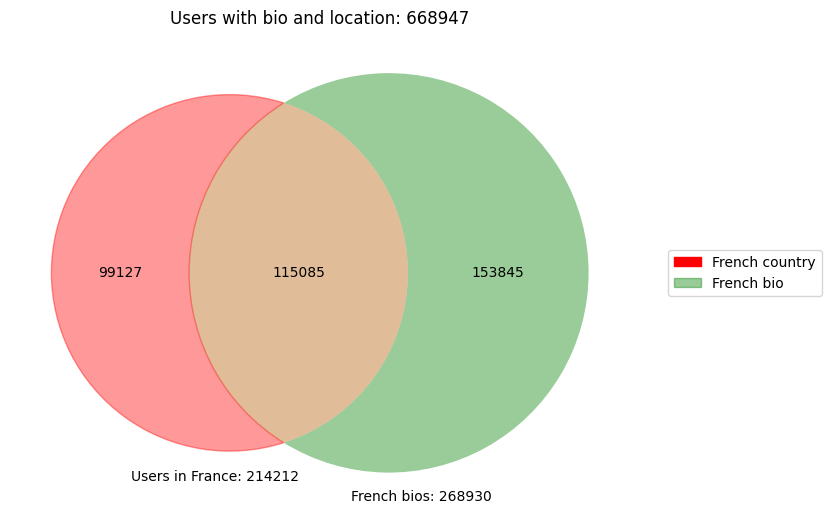

In [32]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Calculate the intersections
french_country_french_language = lang[(lang['country'] == 'France') & (lang['language'] == 'fr')].shape[0]
french_country_other_language = lang[(lang['country'] == 'France') & (lang['language'] != 'fr')].shape[0]

french_country = lang[lang['country'] == 'France'].shape[0]
french_bio = lang[lang['language'] == 'fr'].shape[0]

users_with_both = lang[(lang['location'].notna()) & (lang['description_cleantext'].notna())].shape[0]

# Define the set sizes and the intersection sizes
venn_labels = {'10': french_country_other_language, 
               '01': french_bio - french_country_french_language, 
               '11': french_country_french_language}

# Calculate the total number of users
total_users = users_with_both

plt.figure(figsize=(8, 8))
venn = venn2(subsets=venn_labels, set_labels=(None, None))

# Set 'French country' to red
venn.get_patch_by_id('10').set_color('red')

# Add a title
plt.title(f'Users with bio and location: {total_users}')

# Create the legend
french_country_patch = mpatches.Patch(color='red', label='French country')  # Set 'French country' to red in the legend
french_language_patch = mpatches.Patch(color=venn.get_patch_by_id('01').get_facecolor(), label='French bio')
plt.legend(handles=[french_country_patch, french_language_patch], bbox_to_anchor=(1.05, 0.5), loc='center left')

# Add the total count per category underneath each circle
plt.text(-0.25, -0.5, f'Users in France: {french_country}', ha='center')
plt.text(0.25, -0.55, f'French bios: {french_bio}', ha='center')

# Display the plot
plt.show()

In [26]:
#separate dfs for the different categories
french_bio_not_france = lang[(lang['language'] == 'fr') & (lang['country'] != 'France')]
in_france_nofrenc_bio = lang[(lang['language'] != 'fr') & (lang['country'] == 'France')]
bio_and_country = lang[(lang['language'] == 'fr') & (lang['country'] == 'France')]

In [31]:
summary_stats(bio_and_country, print_dtypes=False)

Shape of DataFrame:  (115085, 13)

Columns in DataFrame:  ['follower_id', 'screen_name', 'description', 'timestamp_utc', 'location', 'tweets', 'followers', 'friends', 'likes', 'lists', 'description_cleantext', 'language', 'country']

Number of unique values in 'follower_id':  115085
Number of duplicate values in 'follower_id':  0

Number of missing values in each column:
'follower_id':  0
'screen_name':  0
'description':  0
'timestamp_utc':  0
'location':  0
'tweets':  0
'followers':  0
'friends':  0
'likes':  0
'lists':  0
'description_cleantext':  0
'language':  0
'country':  0

Number of duplicate rows:  0


In [32]:
# how many rows in french_bio_not_france in the column location are NA?
french_bio_not_france['location'].isna().sum()

#print a selected interval of the rows in french_bio_not_france that are NA in location
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
french_bio_not_france[french_bio_not_france['location'].isna()][['description_cleantext', 'language', 'location', 'country']].iloc[20:30]

,description_cleantext,language,location,country
263,Assistance Marketing aux entreprises et aux organisations.Follow me!,fr,NaN,Other
280,Quand le silence devient notre seule option...!!!!!,fr,NaN,Other
307,Tout £st possible à celui qui cΠoi,fr,NaN,Other
315,Ex président de la fédération des buralistes d'Ile de France,fr,NaN,Other
374,Co-créateur du projet @transmission_s_ Salarié de la protection de l'enfance Militant #Paris13 Acteur dans la troupe des @amis_1871,fr,NaN,Other
394,"du soleil, des fleurs, du rock et beaucoup d’amour",fr,NaN,Other
405,Artiste peintre et écrivain en art spirituel divine et sculpteur,fr,NaN,Other
418,Rien d'spécial,fr,NaN,Other
420,Life is a Joke. Vie ta vie au jour le jour. BrunoMars.Instagram&Snapchat: jujubb2,fr,NaN,Other
438,"Journaliste France Culture, Vannes - Paris Paris - Vannes du reportage ici et là-bas.",fr,NaN,Other


In [27]:
summary_stats(bio_and_country, print_dtypes=False)

Shape of DataFrame:  (115085, 13)

Columns in DataFrame:  ['follower_id', 'screen_name', 'description', 'timestamp_utc', 'location', 'tweets', 'followers', 'friends', 'likes', 'lists', 'description_cleantext', 'language', 'country']

Number of unique values in 'follower_id':  115085
Number of duplicate values in 'follower_id':  0

Number of missing values in each column:
'follower_id':  0
'screen_name':  0
'description':  0
'timestamp_utc':  0
'location':  0
'tweets':  0
'followers':  0
'friends':  0
'likes':  0
'lists':  0
'description_cleantext':  0
'language':  0
'country':  0

Number of duplicate rows:  0


In [23]:
# # #Now write the two dfs to csvs to save them in case something happens
bio_and_country.to_csv('/home/livtollanes/NewData/french/french1.csv', sep=',', encoding='utf-8', index=False, quoting=csv.QUOTE_NONNUMERIC)

In [34]:
lang.loc[lang['follower_id'] == '142130164']

,follower_id,screen_name,description,timestamp_utc,location,tweets,followers,friends,likes,lists,description_cleantext,language,country
421424,142130164,QuietStormType,"hard working, cool breeze with a sense of history.",1.273457e+09,"california, usa",4495.0,134.0,652.0,2073.0,8.0,"hard working, cool breeze with a sense of history.",en,Other


In [35]:
# Python
ids = ['142130164', '3137804943', '871813940967346177', '62842089', '16128220', 
       '1468064171098968067', '842693830361174017', '1144165991452221443', 
       '1455206753608642562', '1415760846085578752', '1366379875779698694', 
       '529073938', '21832017', '425260313', '1110601347353726981', 
       '1257090467147116544', '388207623', '369852156', '934724857035722757', 
       '60729720', '1013222449956212736', '2890749104', '1053582304428412928', 
       '1680485234', '928217120793661441', '950723859556327424', '2953410473', 
       '997050226325311488', '144611104', '52023514', '917814209248972801', 
       '879024865386385409', '3154757889', '908510070123659267', '168414963', 
       '1667169475', '839147987628609537', '354649070', '117491100', '72262176']
selected_rows = lang.loc[lang['follower_id'].isin(ids)]

In [36]:
selected_rows

,follower_id,screen_name,description,timestamp_utc,location,tweets,followers,friends,likes,lists,description_cleantext,language,country
46939,52023514,thatommereki,"The essence of compassion, duty & style. Writer. Speaker. Diplomat. Entrepreneur. GQ Best Dressed Man. Global Ambassador @africanyouthsec @undp @oneyoungworld",1.246273e+09,"johannesburg, south africa",23543.0,3264.0,4972.0,5667.0,34.0,"The essence of compassion, duty & style. Writer. Speaker. Diplomat. Entrepreneur. GQ Best Dressed Man. Global Ambassador @africanyouthsec @undp @oneyoungworld",en,Other
70688,1053582304428412928,Poks_Tau,WEIRD::\n\nWONDERFUL EXCITING INTERESTING REAL DIFFERENT,1.540029e+09,"tembisa, south africa",1779.0,308.0,4999.0,4790.0,0.0,WEIRD::WONDERFUL EXCITING INTERESTING REAL DIFFERENT,de,Other
74558,1366379875779698694,GiuseppePaci991,Ogni bella azione umana è il prodotto dell'entusiasmo! ❤️‍🔥,1.614605e+09,(mondragone beach) campania.,604.0,349.0,3515.0,3157.0,0.0,Ogni bella azione umana è il prodotto dell'entusiasmo!,it,Other
91783,3137804943,DjPNasty1,@buffalo_schools SPED Teacher ( / DJ (Seneca Casino's Resident) Takes a certain type of man 2 teach 2 be far from Hood but 2 understand the streets djpnasty(IG),1.428256e+09,buffalo ny,24464.0,825.0,3708.0,23983.0,7.0,@buffalo_schools SPED Teacher ( / DJ (Seneca Casino's Resident) Takes a certain type of man 2 teach 2 be far from Hood but 2 understand the streets djpnasty(IG),en,Other
148723,842693830361174017,ngdevos_21,just like the sun I'll rise again 🏜🌞☀️,1.489749e+09,in my thoughts,295.0,476.0,3822.0,30708.0,0.0,just like the sun I'll rise again,et,Other
205923,879024865386385409,V91Jones,A true world celeb 🤟❤️🤟💚💙💜💛🧡 ▶️gumball3000🤍biz4funzies🖤Travel 🤎Friends✨Family🏉Partying☮️🌴 Highpasstofreedom 🎾Tennis 🥅pi🌟Poker 💯 🌴🍐🎶🇺🇳,1.498411e+09,ireland,2525.0,1338.0,4979.0,3063.0,20.0,A true world celeb gumball3000biz4funziesTravel FriendsFamilyPartying Highpasstofreedom Tennis piPoker,en,Other
210203,1110601347353726981,Tsoaledi1,simplicity is the most sophisticated. 🕳️,1.553623e+09,"pretoria, south africa",415.0,807.0,4555.0,17042.0,0.0,simplicity is the most sophisticated.,en,Other
253783,908510070123659267,bestgiftshere,"Gifts at every price point, for every shopper. #bestgiftshere",1.505441e+09,"atlanta, ga",10358.0,1057.0,2595.0,9701.0,6.0,"Gifts at every price point, for every shopper. #bestgiftshere",en,Other
259914,168414963,lbabyluv,NaN,1.279526e+09,NaN,439.0,224.0,4917.0,537.0,3.0,NaN,unknown,Other
330704,72262176,Seasoned_Africa,Creative Craft... Brands. Concepts. Execution. http://seasoned.africa,1.252323e+09,NaN,346264.0,121253.0,2250.0,1331.0,152.0,Creative Craft... Brands. Concepts. Execution. http://seasoned.africa,en,Other
